---
title: Python Assignment 3
subtitle: Efficient Frontier
author: Brady Bulls
date: today
date-format: "MMMM D YYYY"
format:
  html:
    theme: sandstone
    toc: false
warning: false
---

## Part A:

### Step 3: Review and modify collab code

In [22]:
import math as m
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf

plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'serif'

import warnings; warnings.simplefilter('ignore')

In [4]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights) * 252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [5]:
def random_portfolio(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std
    return results, weights_record

#### Collecting S&P 500 tickers from the web

In [6]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_constituents = pd.read_html(sp_url, header=0)[0]

In [7]:
stocks_sp500 = sp500_constituents['Symbol']

In [8]:
# Transpose the oclumn vector to a row vector and covert pandas into a list.
tickers = stocks_sp500.T
tickers = tickers.values.tolist()

tickers.remove('BF.B')
tickers.remove('BRK.B')

In [9]:
type(tickers)

list

In [10]:
len(tickers)

501

In [11]:
import scipy.optimize as sco

In [12]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [13]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0, 1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [14]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]
    
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0.0, 1.0) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [15]:
def display_ef_with_selected2(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252

    max_sharpe2 = (rp - risk_free_rate)/ sdp

    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualized Return:", round(rp,2))
    print ("Annualized Volatility:", round(sdp,2))
    print ("Sharpe ratio =", max_sharpe)
    print ("Sharpe ratio2 =", round(max_sharpe2, 4))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualized Return:", round(rp_min,2))
    print ("Annualized Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(data.columns):
        print (txt,":","annualized return",round(an_rt[i],2),", annualized volatility:",round(an_vol[i],2))
    print ("-"*80)

    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(data.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualized volatility')
    ax.set_ylabel('annualized returns')
    ax.legend(labelspacing=0.8)
    
    return max_sharpe_allocation, max_sharpe2

In [14]:
import random
stocks = random.sample(tickers, 10)
stocks

data = pd.DataFrame()
data = yf.download(stocks, start="2017-01-01", end="2023-12-31", progress=True)['Adj Close'].dropna()


returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios= 5000
risk_free_rate = 0.0378

[*********************100%%**********************]  10 of 10 completed


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.29
Annualized Volatility: 0.3
Sharpe ratio =  message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8437966417302262
       x: [ 2.668e-01  1.807e-02  4.852e-17  0.000e+00  4.975e-01
            4.494e-02  0.000e+00  7.752e-18  1.727e-01  3.944e-17]
     nit: 8
     jac: [-1.245e-01 -1.243e-01  1.290e-01 -1.329e-02 -1.249e-01
           -1.235e-01 -7.518e-02 -1.184e-01 -1.242e-01  1.635e-01]
    nfev: 89
    njev: 8
Sharpe ratio2 = 0.8438


Ticker        ACN  ALGN  AVB  CCI   LRCX  MKTX  PSX  SYK    TJX  ZION
allocation  26.68  1.81  0.0  0.0  49.75  4.49  0.0  0.0  17.27   0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualized Return: 0.14
Annualized Volatility: 0.2


Ticker        ACN  ALGN    AVB    CCI  LRCX   MKTX   PSX  SYK  

Ticker,ACN,ALGN,AVB,CCI,LRCX,MKTX,PSX,SYK,TJX,ZION
allocation,26.68,1.81,0.0,0.0,49.75,4.49,0.0,0.0,17.27,0.0


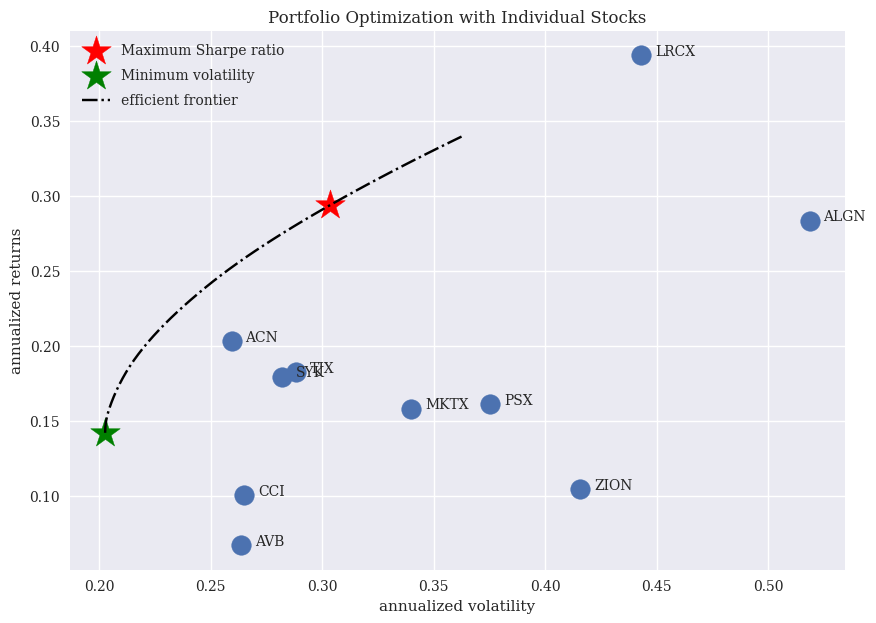

In [37]:
%%time

looping = 1000

max_iterated_SR = 0
max_allocation = pd.DataFrame()

for i in range(looping):
    stocks = random.sample(tickers, 10)
    data = pd.DataFrame()
    # I passed the list to yf.download instead of a for loop to try and reduce
    # the number of yahoo calls.
    data = yf.download(stocks, start="2017-01-01", end="2023-12-31", progress=False)['Adj Close'].dropna()

returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 5000
risk_free_rate = 0.0378

max2, max_SR = display_ef_with_selected2(mean_returns, cov_matrix, risk_free_rate)
if max_SR >= max_iterated_SR:
    max_iterated_SR = max_SR
    max_allocation = max2

print(f'The Highest SR={max_iterated_SR:.4f}')
print('\n')
print('\n')

max_allocation

{{< pagebreak >}}

### Step 4: The Hilpisch Code

In [5]:
import math as m
import numpy as np
import pandas as pd
import scipy.stats as scs
import statsmodels.api as sm

import matplotlib.pyplot as plt

import yfinance as yf

plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

In [6]:
def normality_test(arr):
    '''Tests or normality distribution of given data set.
    
    Prametters
    ==========
    array: ndarray
        object to generate statistics on
    '''
    print('Skew of data set %14.3f' % scs.skew(arr))
    print('Skew test p-value %14.3f' % scs.skewtest(arr)[1])
    print('Kurt of data set %14.3f' % scs.kurtosis(arr))
    print('Kurt test p-values %14.3f' % scs.kurtosistest(arr)[1])
    print('Norm test p-values %14.3f' % scs.normaltest(arr)[1])

{{< pagebreak >}}

In [7]:
def print_statistcis(array):
    ''' prints selected statistics.
    
    Paramaters
    ==========
    array: ndarray
        object to generate statistics on
    '''
    sta = scs.describe(array)
    print('%14s %15s' % ('statistic', 'value'))
    print(30 * '-')
    print('%14s %15.5f' % ('size', sta[0]))
    print('%14s %15.5f' % ('max', sta[1][1]))
    print('%14s %15.5f' % ('mean', sta[2]))
    print('%14s %15.5f' % ('annual mean', sta[2]*252))
    print('%14s %15.5f' % ('std', np.sqrt(sta[3])))
    print('%14s %15.5f' % ('annual std', np.sqrt(sta[3]*np.sqrt(252))))
    print('%14s %15.5f' % ('skew', sta[4]))
    print('%14s %15.5f' % ('kurtosis', sta[5]))

In [8]:
tickers = ['SPY', 'GLD', 'AAPL', 'MSFT']
mydata = pd.DataFrame()
mydata = yf.download(tickers, start='2010-01-01', end='2020-06-29')['Adj Close']
mydata.isna().any()

[*********************100%%**********************]  4 of 4 completed


Ticker
AAPL    False
GLD     False
MSFT    False
SPY     False
dtype: bool

{{< pagebreak >}}

In [9]:
for t in tickers:
    print(t)
    print_statistcis(mydata[t].pct_change().dropna())

    print(30 * '-')

SPY
     statistic           value
------------------------------
          size      2638.00000
           max         0.09060
          mean         0.00051
   annual mean         0.12814
           std         0.01089
    annual std         0.04340
          skew        -0.60333
      kurtosis        13.90910
------------------------------
GLD
     statistic           value
------------------------------
          size      2638.00000
           max         0.04904
          mean         0.00021
   annual mean         0.05230
           std         0.00995
    annual std         0.03963
          skew        -0.41236
      kurtosis         5.14647
------------------------------
AAPL
     statistic           value
------------------------------
          size      2638.00000
           max         0.11981
          mean         0.00113
   annual mean         0.28601
           std         0.01741
    annual std         0.06936
          skew        -0.14358
      kurtosis         6.3

{{< pagebreak >}}

In [10]:
data = mydata
data = data.dropna()
data

Ticker,AAPL,GLD,MSFT,SPY
Date,,,,
2010-01-04,6.470741,109.800003,23.431591,87.129936
2010-01-05,6.481928,109.699997,23.439150,87.360596
2010-01-06,6.378826,111.510002,23.295313,87.422081
2010-01-07,6.367033,110.820000,23.053051,87.791115
2010-01-08,6.409361,111.370003,23.212042,88.083260
...,...,...,...,...
2020-06-22,87.738304,165.089996,193.985809,294.683685
2020-06-23,89.611069,166.479996,195.281815,296.040314
2020-06-24,88.029274,165.899994,191.345444,288.488739


<Axes: xlabel='Date'>

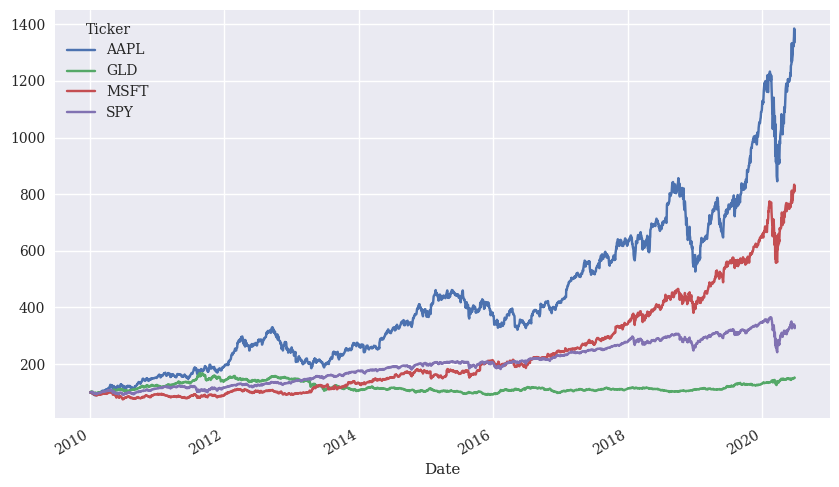

In [11]:
(data / data.iloc[0] * 100).plot(figsize=(10, 6))
# plt.savefig()

{{< pagebreak >}}

In [12]:
log_returns = np.log(data / data.shift(1)).dropna()
log_returns.head()

Ticker,AAPL,GLD,MSFT,SPY
Date,,,,
2010-01-05,0.001727,-0.000911,0.000323,0.002644
2010-01-06,-0.016034,0.016365,-0.006156,0.000704
2010-01-07,-0.001851,-0.006207,-0.010454,0.004212
2010-01-08,0.006626,0.004951,0.006873,0.003322
2010-01-11,-0.008861,0.013201,-0.012802,0.001396


array([[<Axes: title={'center': 'AAPL'}>,
        <Axes: title={'center': 'GLD'}>],
       [<Axes: title={'center': 'MSFT'}>,
        <Axes: title={'center': 'SPY'}>]], dtype=object)

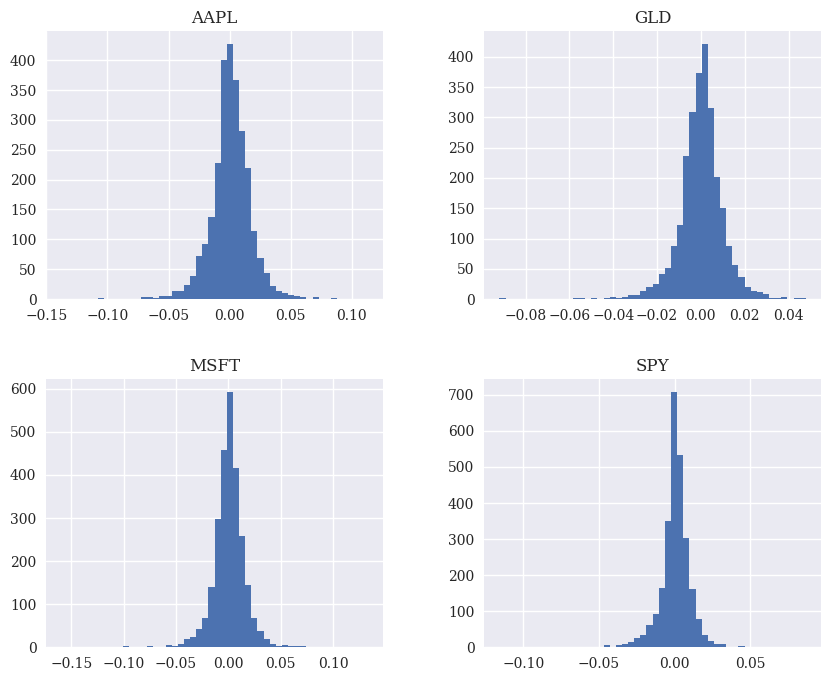

In [13]:
log_returns.hist(bins=50, figsize=(10, 8))
# plt.savefig()

{{< pagebreak >}}

In [14]:
for sym in tickers:
    print('\nResults for symbol {}'.format(sym))
    print(30 * '-')
    log_data = np.array(log_returns[sym].dropna())
    print_statistcis(log_data)


Results for symbol SPY
------------------------------
     statistic           value
------------------------------
          size      2638.00000
           max         0.08673
          mean         0.00045
   annual mean         0.11309
           std         0.01093
    annual std         0.04356
          skew        -0.86337
      kurtosis        14.87487

Results for symbol GLD
------------------------------
     statistic           value
------------------------------
          size      2638.00000
           max         0.04787
          mean         0.00016
   annual mean         0.03979
           std         0.00997
    annual std         0.03972
          skew        -0.51985
      kurtosis         5.62429

Results for symbol AAPL
------------------------------
     statistic           value
------------------------------
          size      2638.00000
           max         0.11316
          mean         0.00098
   annual mean         0.24764
           std         0.017

{{< pagebreak >}}

Text(0, 0.5, 'sample quantiles')

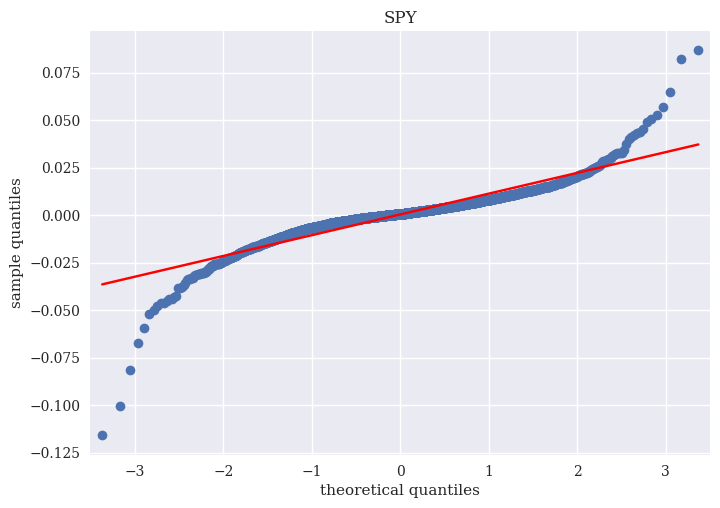

In [15]:
sm.qqplot(log_returns['SPY'].dropna(), line='s')
plt.title('SPY')
plt.xlabel('theoretical quantiles')
plt.ylabel('sample quantiles')
# plt.savefig()

{{< pagebreak >}}

#### Rejecting Normality

In [16]:
for sym in tickers:
    print('\nResults for symbol {}'.format(sym))
    print(32 * '-')
    log_data = np.array(log_returns[sym].dropna())
    normality_test(log_data)


Results for symbol SPY
--------------------------------
Skew of data set         -0.863
Skew test p-value          0.000
Kurt of data set         14.875
Kurt test p-values          0.000
Norm test p-values          0.000

Results for symbol GLD
--------------------------------
Skew of data set         -0.520
Skew test p-value          0.000
Kurt of data set          5.624
Kurt test p-values          0.000
Norm test p-values          0.000

Results for symbol AAPL
--------------------------------
Skew of data set         -0.366
Skew test p-value          0.000
Kurt of data set          6.804
Kurt test p-values          0.000
Norm test p-values          0.000

Results for symbol MSFT
--------------------------------
Skew of data set         -0.233
Skew test p-value          0.000
Kurt of data set         11.286
Kurt test p-values          0.000
Norm test p-values          0.000


{{< pagebreak >}}

#### Portfolio Optimization

##### The Data

In [17]:
noa = len(tickers); print(noa)

4


In [18]:
data = mydata[tickers]; data

Ticker,SPY,GLD,AAPL,MSFT
Date,,,,
2010-01-04,87.129936,109.800003,6.470741,23.431591
2010-01-05,87.360596,109.699997,6.481928,23.439150
2010-01-06,87.422081,111.510002,6.378826,23.295313
2010-01-07,87.791115,110.820000,6.367033,23.053051
2010-01-08,88.083260,111.370003,6.409361,23.212042
...,...,...,...,...
2020-06-22,294.683685,165.089996,87.738304,193.985809
2020-06-23,296.040314,166.479996,89.611069,195.281815
2020-06-24,288.488739,165.899994,88.029274,191.345444


In [19]:
rets = np.log(data / data.shift(1)); rets

Ticker,SPY,GLD,AAPL,MSFT
Date,,,,
2010-01-04,NaN,NaN,NaN,NaN
2010-01-05,0.002644,-0.000911,0.001727,0.000323
2010-01-06,0.000704,0.016365,-0.016034,-0.006156
2010-01-07,0.004212,-0.006207,-0.001851,-0.010454
2010-01-08,0.003322,0.004951,0.006626,0.006873
...,...,...,...,...
2020-06-22,0.006395,0.006441,0.025827,0.027395
2020-06-23,0.004593,0.008384,0.021120,0.006659
2020-06-24,-0.025840,-0.003490,-0.017809,-0.020363


array([[<Axes: title={'center': 'SPY'}>, <Axes: title={'center': 'GLD'}>],
       [<Axes: title={'center': 'AAPL'}>,
        <Axes: title={'center': 'MSFT'}>]], dtype=object)

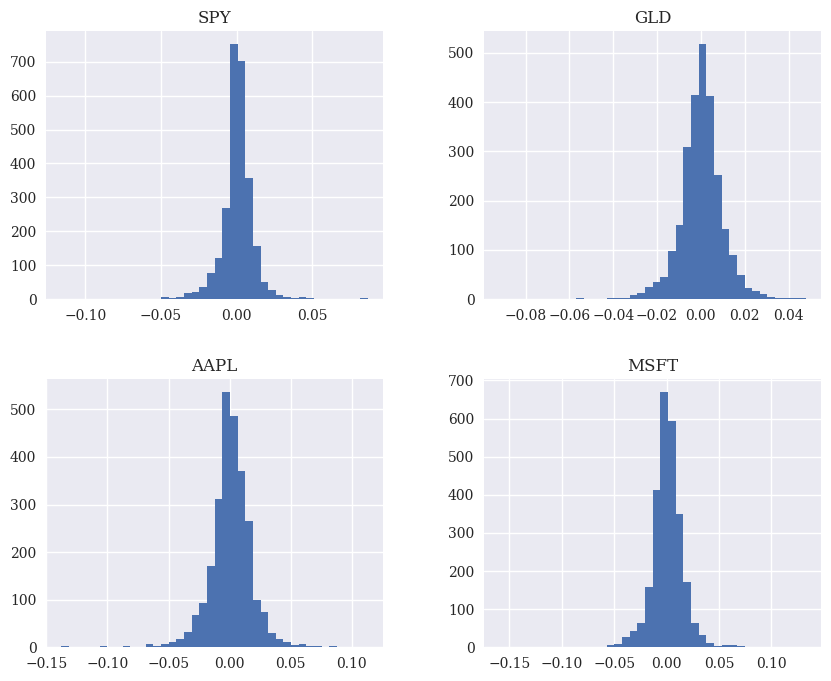

In [20]:
rets.hist(bins=40, figsize=(10,8))
# plt.savefig()

In [21]:
rets.mean() * 252

Ticker
SPY     0.113092
GLD     0.039794
AAPL    0.247640
MSFT    0.199874
dtype: float64

In [22]:
rets.cov() * 252


Ticker,SPY,GLD,AAPL,MSFT
Ticker,,,,
SPY,0.030126,0.000257,0.031757,0.032632
GLD,0.000257,0.025043,0.001011,-0.000259
AAPL,0.031757,0.001011,0.076588,0.038213
MSFT,0.032632,-0.000259,0.038213,0.063158


##### The Basic Theory

In [23]:
weights = np.random.random(noa)
weights /= np.sum(weights)
print(weights); print(noa)

[0.00754126 0.40529023 0.17545843 0.41171008]
4


In [24]:
weights

array([0.00754126, 0.40529023, 0.17545843, 0.41171008])

In [25]:
weights.sum()

1.0

In [26]:
np.sum(rets.mean() * weights) * 252

0.14272176674830248

In [27]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.02304539189458869

In [28]:
m.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.1518070877613713

In [7]:
def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252
def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

In [31]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
prets = np.array(prets)
pvols = np.array(pvols)

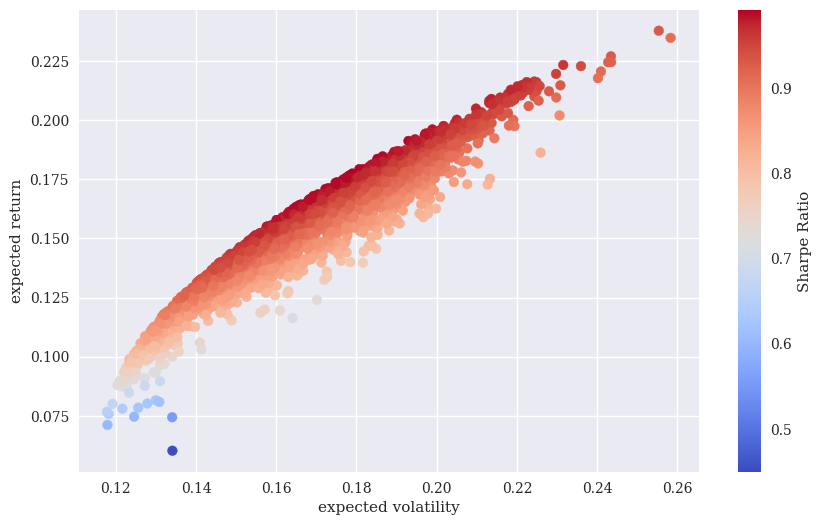

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols,
            marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe Ratio')
# plt.savefig()

### Portfolio Optimizations

In [52]:
import scipy.optimize as sco

In [53]:
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

In [62]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})

In [55]:
bnds = tuple((0, 1) for x in range(noa))

In [56]:
eweights = np.array(noa * [1. / noa,])
eweights

array([0.25, 0.25, 0.25, 0.25])

In [57]:
min_func_sharpe(weights)

-0.8213218692625033

In [63]:
%%time
opts = sco.minimize(min_func_sharpe, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons)

port_ret(opts['x']) / port_vol(opts['x'])

CPU times: total: 15.6 ms
Wall time: 21 ms


0.995018725618054

##### Find the highest SR possible from selecting ten assets from S&P 500 firms and optimizing the SR

In [5]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_constituents = pd.read_html(sp_url, header=0)[0]

stocks_sp500 = sp500_constituents['Symbol']
tickers = stocks_sp500.T
tickers = tickers.values.tolist()

tickers.remove('BF.B')
tickers.remove('BRK.B')

len(tickers)

501

In [4]:
import random
import scipy.optimize as sco

noa = 10

In [91]:
%%time


loops = 2000

max_iterated_SR = 0
max_allocation = None
best_stocks = None

for i in range(loops):
    stocks = random.sample(tickers, 10)

    data = pd.DataFrame()
    data = yf.download(stocks, start="2017-01-01", end="2023-12-31", progress=False)['Adj Close'].dropna()

    rets = np.log(data / data.shift(1))

    def min_func_sharpe(weights):
        return -port_ret(weights) / port_vol(weights)

    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    bnds = tuple((0, 1) for x in range(noa))
    eweights = np.array(noa * [1. / noa,])
    min_func_sharpe(eweights)

    opts = sco.minimize(min_func_sharpe, eweights,
                        method='SLSQP', bounds=bnds,
                        constraints=cons)
    
    current_SR = -opts.fun
    if current_SR > max_iterated_SR:
        max_iterated_SR = current_SR
        max_allocation = opts.x
        best_stocks = stocks


print('\nResults')
print(30 * '-')
print(f'Highest Sharpe Ratio: {max_iterated_SR:.4f}')
print(30 * '-')
print(f'Optimal Allocation:', max_allocation)
print(30 * '-')
print(f'Selected Stocks: {best_stocks}')


1 Failed download:
['BRO']: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)"))



Results
------------------------------
Highest Sharpe Ratio: 7.5334
------------------------------
Optimal Allocation: [0.00000000e+00 7.11056901e-15 1.39175443e-01 8.25501539e-15
 1.38723680e-01 3.35536321e-01 3.86564556e-01 5.21155907e-15
 0.00000000e+00 0.00000000e+00]
------------------------------
Selected Stocks: ['NRG', 'DRI', 'SBUX', 'CAH', 'RSG', 'FOX', 'CSCO', 'LEN', 'TEL', 'VLTO']
CPU times: total: 10min 5s
Wall time: 15min 46s


##### Just for fun, the optimal S&P 500 Portfolio

In [8]:
%%time

noa = len(tickers)
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})
bnds = tuple((0, 1) for _ in range(noa))
eweights = np.array(noa * [1. / noa,])

#min_func_sharpe(weights)

data = pd.DataFrame()
data = yf.download(tickers, start="2017-01-01", end="2023-12-31", progress=True)['Adj Close'].dropna()

rets = np.log(data / data.shift(1))

def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(noa))
eweights = np.array(noa * [1. / noa,])
min_func_sharpe(eweights)

opts = sco.minimize(min_func_sharpe, eweights,
                    method='SLSQP', bounds=bnds,
                    constraints=cons)

optimal_weights_df = pd.DataFrame(opts.x, index=data.columns, columns=['Optimal Weights'])

print(optimal_weights_df)

[*********************100%%**********************]  501 of 501 completed


        Optimal Weights
Ticker                 
A          2.851806e-11
AAL        4.519820e-11
AAPL       1.956665e-11
ABBV       2.926920e-11
ABNB       1.377566e-10
...                 ...
YUM        4.485146e-12
ZBH        9.162573e-12
ZBRA       1.815472e-11
ZION       1.511795e-10
ZTS        1.559570e-11

[501 rows x 1 columns]
CPU times: total: 12min 52s
Wall time: 12min 55s


In [9]:
optimal_weights_df

,Optimal Weights
Ticker,
A,2.851806e-11
AAL,4.519820e-11
AAPL,1.956665e-11
ABBV,2.926920e-11
ABNB,1.377566e-10
...,...
YUM,4.485146e-12
ZBH,9.162573e-12
ZBRA,1.815472e-11


In [19]:
%reset -f

Looking at the datatable for the "optimal SP 500" list, it seems that there are some computational limitations, as after a certain point, the optimal weights are just zeros.

## Part B

### Excersise 2.1: Data Manipulation

In [1]:
import requests
import pandas as pd

url = 'https://raw.githubusercontent.com/datasets/london-life-expectancy/master/data/female-life-expectancy.csv'
response = requests.get(url)
if response.status_code == 200:
    with open('female-life-expectancy.csv', 'wb') as file:
        file.write(response.content)
    print(f"File succesfully downloaded.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File succesfully downloaded.


In [44]:
raw_data = pd.read_csv('female-life-expectancy.csv')

In [47]:
le_female = raw_data
le_female.rename(columns={'Value': 'Life Expect'}, inplace=True)

In [57]:
mean = le_female['Life Expect'].mean()
median = le_female['Life Expect'].median()
descrip = le_female['Life Expect'].describe()

print('\nFemale Life Expectancy Statistics')
print(35 * '-')
print(f'Mean: {mean:.3f}')
print(f'Median: {median:.3f}')
print(f'Descriptive Stats: {descrip}')

del raw_data, le_female


Female Life Expectancy Statistics
-----------------------------------
Mean: 81.280
Median: 81.100
Descriptive Stats: count    988.000000
mean      81.280104
std        1.885620
min       77.400000
25%       79.900000
50%       81.100000
75%       82.650000
max       86.700000
Name: Life Expect, dtype: float64


### Excersise 2.2: Data import and export

In [61]:
url = 'https://raw.githubusercontent.com/datasets/population-reference-bureau/master/data/us/fertility/data/us-fertility.csv'
response = requests.get(url)
if response.status_code == 200:
    with open('us-fertility.csv', 'wb') as file:
        file.write(response.content)
    print(f"File succesfully downloaded.")
    del file
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File succesfully downloaded.


In [3]:
fertilityUS = pd.read_csv('us-fertility.csv')
fertilityUS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Type       936 non-null    object 
 1   TimeFrame  936 non-null    int64  
 2   Data       936 non-null    float64
 3   NameFIPS   936 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 29.4+ KB


In [7]:
fertilityUS['NameFIPS'].value_counts()

NameFIPS
Alabama 01                 18
Alaska 02                  18
Nevada 32                  18
New Hampshire 33           18
New Jersey 34              18
New Mexico 35              18
New York 36                18
North Carolina 37          18
North Dakota 38            18
Ohio 39                    18
Oklahoma 40                18
Oregon 41                  18
Pennsylvania 42            18
Rhode Island 44            18
South Carolina 45          18
South Dakota 46            18
Tennessee 47               18
Texas 48                   18
Utah 49                    18
Vermont 50                 18
Virginia 51                18
Washington 53              18
West Virginia 54           18
Wisconsin 55               18
Wyoming 56                 18
Nebraska 31                18
Montana 30                 18
Missouri 29                18
Idaho 16                   18
Arizona 04                 18
Arkansas 05                18
California 06              18
Colorado 08                18
C

In [24]:
grouped_states = fertilityUS.groupby('TimeFrame')['Data'].mean()
grouped_states

TimeFrame
2000    2.088654
2001    2.075577
2002    1.992885
2003    2.022308
2004    2.027115
2005    2.030385
2006    2.092500
2007    2.116731
2008    2.085385
2009    2.004808
2010    1.943462
2011    1.910577
2012    1.896923
2013    1.877500
2014    1.880962
2015    1.866538
2016    1.841538
2017    1.788077
Name: Data, dtype: float64

In [25]:
grouped_year = fertilityUS.groupby('NameFIPS')['Data'].mean()
grouped_year

NameFIPS
Alabama 01                 1.907778
Alaska 02                  2.309444
Arizona 04                 2.204444
Arkansas 05                2.046667
California 06              2.007778
Colorado 08                1.983333
Connecticut 09             1.786667
Delaware 10                1.936111
District of Columbia 11    1.665556
Florida 12                 1.932222
Georgia 13                 2.036111
Hawaii 15                  2.163333
Idaho 16                   2.255000
Illinois 17                1.945000
Indiana 18                 2.006111
Iowa 19                    2.023333
Kansas 20                  2.130000
Kentucky 21                1.970556
Louisiana 22               1.992778
Maine 23                   1.691667
Maryland 24                1.910000
Massachusetts 25           1.683333
Michigan 26                1.872778
Minnesota 27               2.003333
Mississippi 28             2.011111
Missouri 29                1.954444
Montana 30                 1.985000
Nebraska 31        

In [32]:
states = ['Georgia 13', 'South Carolina 45', 'Florida 12']
southdata = fertilityUS.loc[fertilityUS['NameFIPS'].isin(states)]
southdata.head(5)

,Type,TimeFrame,Data,NameFIPS
162,State,2000,2.16,Florida 12
163,State,2001,2.17,Florida 12
164,State,2002,2.00,Florida 12
165,State,2003,2.01,Florida 12
166,State,2004,2.02,Florida 12


In [35]:
southsubset = southdata.iloc[0:20, 3:4]
southsubset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 162 to 181
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   NameFIPS  20 non-null     object
dtypes: object(1)
memory usage: 320.0+ bytes


In [38]:
%reset -f

### Excersise 2.3: Hypothesis Testing with Fertility Data

In [8]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression

In [40]:
url = "https://raw.githubusercontent.com/datasets/population-reference-bureau/master/data/us/fertility/data/us-fertility.csv"

fertility = pd.read_csv(url)
fertility

,Type,TimeFrame,Data,NameFIPS
0,State,2000,2.02,Alabama 01
1,State,2001,1.94,Alabama 01
2,State,2002,1.88,Alabama 01
3,State,2003,1.92,Alabama 01
4,State,2004,1.91,Alabama 01
...,...,...,...,...
931,Country,2013,1.86,United States US
932,Country,2014,1.86,United States US
933,Country,2015,1.84,United States US
934,Country,2016,1.82,United States US


In [52]:
null = 2.1
fertility_2017 = fertility[fertility['TimeFrame'] == 2017]['Data']

test = sm.stats.ztest(fertility_2017, value = null, alternative = "smaller")
d = {'Z': [test[0]], 'P-Value': [test[1]]}
df = pd.DataFrame(data=d)
df
# print(f"T-statistic: {t_statistic}")
# print(f"P-value: {p_value}")
# print(f"Degrees of Freedom: {degrees_of_freedom}")

,Z,P-Value
0,-13.72876,3.414602e-43


### Excersise 2.4: Linear Regression

In [15]:
tips = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv')
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [17]:
tipsN = pd.get_dummies(tips, columns=['sex','smoker'], dtype=float) # this converts the categorical variables into dummies.
tipsN.head()

,total_bill,tip,day,time,size,sex_Female,sex_Male,smoker_No,smoker_Yes
0,16.99,1.01,Sun,Dinner,2,1.0,0.0,1.0,0.0
1,10.34,1.66,Sun,Dinner,3,0.0,1.0,1.0,0.0
2,21.01,3.50,Sun,Dinner,3,0.0,1.0,1.0,0.0
3,23.68,3.31,Sun,Dinner,2,0.0,1.0,1.0,0.0
4,24.59,3.61,Sun,Dinner,4,1.0,0.0,1.0,0.0


In [18]:
tipsNew = tipsN.dropna()

In [19]:
XVars = tipsNew[['sex_Male', 'smoker_Yes', 'total_bill']]
Y = tipsNew['tip']

XVars = sm.add_constant(XVars)
model = sm.OLS(Y, XVars).fit()
predictions = model.predict(XVars)

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                    tip   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     67.99
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           7.39e-32
Time:                        11:56:29   Log-Likelihood:                -349.90
No. Observations:                 244   AIC:                             707.8
Df Residuals:                     240   BIC:                             721.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9770      0.178      5.484      0.0

### Exercise 2.5: Basic Plots

In [20]:
import seaborn as s
s.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'dowjones',
 'exercise',
 'flights',
 'fmri',
 'geyser',
 'glue',
 'healthexp',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'seaice',
 'taxis',
 'tips',
 'titanic']

In [24]:
s.load_dataset('flights').head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


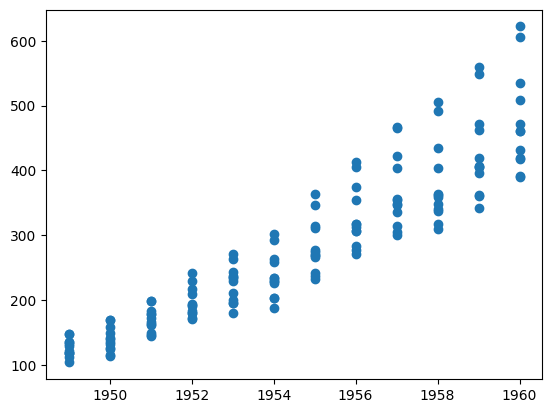

In [27]:
flight_data = s.load_dataset('flights')
plt.scatter(flight_data['year'], flight_data['passengers'])

### Exercise 2.6: Distribution Plot

In [29]:
mpg = s.load_dataset('mpg')
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


C:\Users\Brady\AppData\Local\Temp\ipykernel_10176\981862617.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  s.distplot(subset['mpg'], hist = False, kde=True, kde_kws={'linewidth':3}, label = c)
C:\Users\Brady\AppData\Local\Temp\ipykernel_10176\981862617.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe57

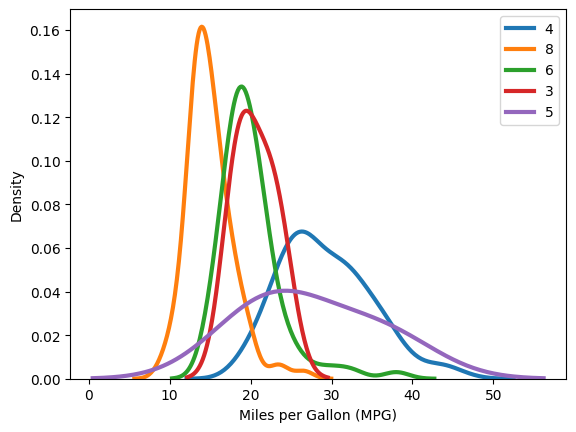

In [39]:
cylinders = [4, 8, 6, 3, 5]
for c in cylinders:
    subset = mpg[mpg['cylinders'] == c]
    # Use line_kws to set the linewidth for the KDE plot
    s.distplot(subset['mpg'], hist = False, kde=True, kde_kws={'linewidth':3}, label = c)

plt.xlabel('Miles per Gallon (MPG)')
plt.legend(cylinders)
plt.show()

### Exercise 2.7: Box Plot

In [40]:
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


Text(0, 0.5, 'Horse Power')

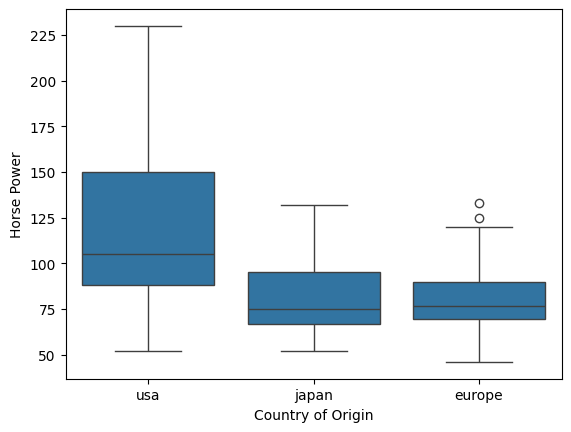

In [43]:
s.boxplot(x='origin', y='horsepower', data = mpg)
plt.xlabel('Country of Origin')
plt.ylabel('Horse Power')

Text(0, 0.5, 'Miles per Gallon')

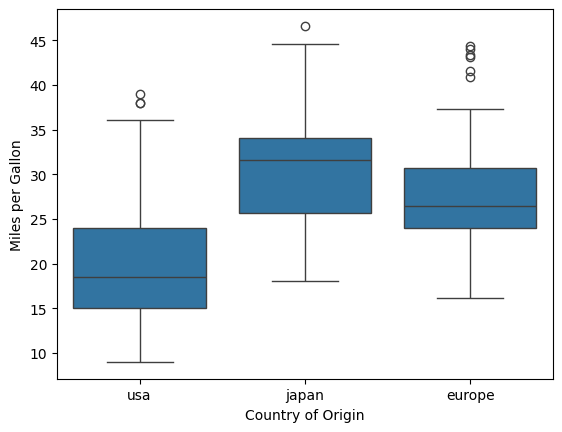

In [44]:
s.boxplot(x='origin', y='mpg', data = mpg)
plt.xlabel('Country of Origin')
plt.ylabel('Miles per Gallon')